# Train MPOX detection models

Finetune resnet18 model using MSID in binary mode
Will fine tune a CNN model:
- Dataset: MSID converted into a binary dataset
- Pretrained model: ResNet-18 trained with Imagenet-1k
- Hyperparameters:
	- BS: [16 32 64]
	- LR:  self selected
    - nbr epochs: 100

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import torch
import umap
from pprint import pprint
from uuid import uuid4

from eccore.ipython import nb_setup
nb_setup()

from utils import run_experiment, create_image_features, plot_features, model_weight_files, parse_saved_fnames, ROOT


from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback
from pathlib import Path
# from torchvision.models import resnet18,
from fastai import __version__ as fastai_version
print(f"Using fastai version {fastai_version}")

saved = ROOT / "saved"
assert saved.is_dir()
data = ROOT / "data"
assert data.is_dir()
msid = data / "MSID-binary"
assert msid.is_dir()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Added path: /home/vtec/projects/bio/mpox-prestudy/src
Set autoreload mode
Using fastai version 2.8.3


'cuda'

In [2]:
files_msid = get_image_files(msid)
files_msid_mpox = get_image_files(msid/'Monkeypox')
files_msid_others = get_image_files(msid/'Others')
print(f"MSID:  {len(files_msid):5,d} images found including {len(files_msid_mpox):5,d} Monkeypox and {len(files_msid_others):5,d} Others images")

MSID:    770 images found including   279 Monkeypox and   491 Others images


## Create Training dataloader and utility fn

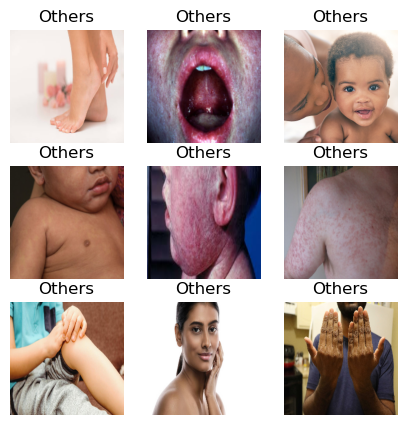

In [3]:
dls = ImageDataLoaders.from_folder(
    path=msid,
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
plt.style.use('default')
dls.show_batch(max_n=9, figsize=(5,5), show=True)

In [4]:
# run_experiment(resnet18, dls=dls, dataset='msid-binary',n_epoch=10, lr=1e-3, bs=32, suggested_lr='minimum')

## Explore paper's hyperparameters

| # | lr | bs | Train Loss | Val Acc | Val Loss | Val Recall  | Val Specificity | Val Precision | Val Acc | Val F1 |
| - | -  | -  | -          | -       | -        | -           | -               | -             | -       | -      |
| 1 |1e-3| 32 |  1.33E-06  | 99.4987 | 0.0375   | 0.988795518 | 1               | 1             | 0.994987469 | 0.994366197 |
| 2 |1e-3| 16 |  1.71E-07  | 99.4987 | 0.0235   | 0.994397759 | 0.995464853     | 0.994397759   | 0.994987469 | 0.994397759 |
| 3 |1e-3| 64 |  1.51E-05  | 97.7444 | 0.0784   | 0.969187675 | 0.984126984     | 0.980169972   | 0.977443609 | 0.974647887 |
| 4 |1e-4| 32 |  1.00E-03  | 97.619  | 0.0662   | 0.966386555 | 0.984126984     | 0.980113636   | 0.976190476 | 0.973201693 |


### Finetuning

In [23]:
# run_experiment?

Running experiment 1/4: bs=32
> Finding learning rate...


  lrs.minimum: 8.32e-03 
  lrs.steep  : 3.31e-04  
  lrs.valley : 1.00e-03


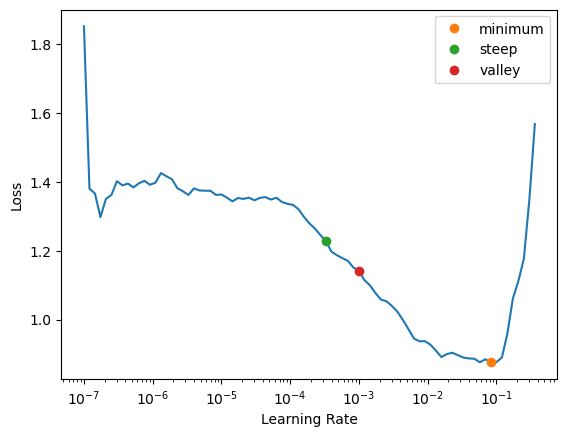

  Using valley learning rate: 1.00e-03

> Fine-tuning resnet18 on msid-binary for 100 epochs with batch size 32...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.906499,0.318441,0.912621,0.930693,0.896104,0.921569,00:01


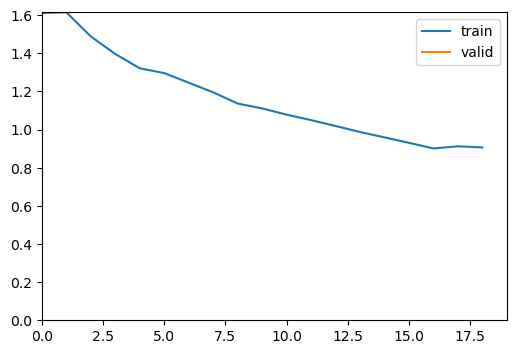

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.545628,0.308814,0.893204,0.938776,0.889610,0.915423,00:01
1,0.398604,0.275987,0.912621,0.940000,0.902597,0.926108,00:01
2,0.319849,0.260592,0.912621,0.949495,0.909091,0.930693,00:01
3,0.280216,0.241594,0.902913,0.948980,0.902597,0.925373,00:01
4,0.248436,0.230134,0.941748,0.950980,0.928571,0.946341,00:01
5,0.192589,0.245909,0.932039,0.950495,0.922078,0.941176,00:01
6,0.160708,0.247246,0.932039,0.950495,0.922078,0.941176,00:01
7,0.140218,0.240644,0.951456,0.951456,0.935065,0.951456,00:01
8,0.114951,0.224831,0.951456,0.942308,0.928571,0.946860,00:01
9,0.094453,0.229388,0.941748,0.950980,0.928571,0.946341,00:02


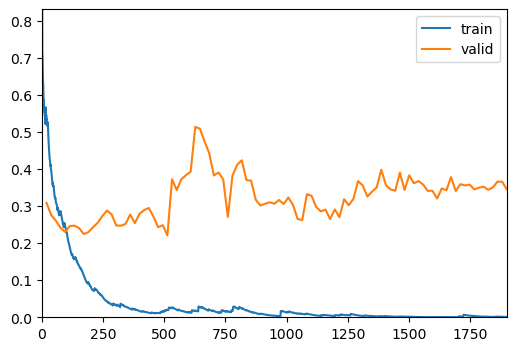

> Saving training records...
  Weights:  resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6.pth
  Metrics:  resnet18_100_32_1.0e-03_msid-binary_metrics_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6.csv
  Losses:   resnet18_100_32_1.0e-03_msid-binary_losses_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6.csv
  Metadata: resnet18_100_32_1.0e-03_msid-binary_metadata_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6.txt
  Curves:   resnet18_100_32_1.0e-03_msid-binary_curves_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 100
Batch Size: 32
Learning Rate: 1.0e-03
Metrics:
	recall_score: 0.990291
	precision_score: 0.935780
	accuracy: 0.948052
	f1_score: 0.962264

UID: 5e1525da-81f7-4a7a-bb8e-725a0cbe24c6
----------------------------------------

Running experiment 2/4: bs=16
> Finding learning rate...


  lrs.minimum: 8.32e-03 
  lrs.steep  : 1.45e-03  
  lrs.valley : 2.09e-03


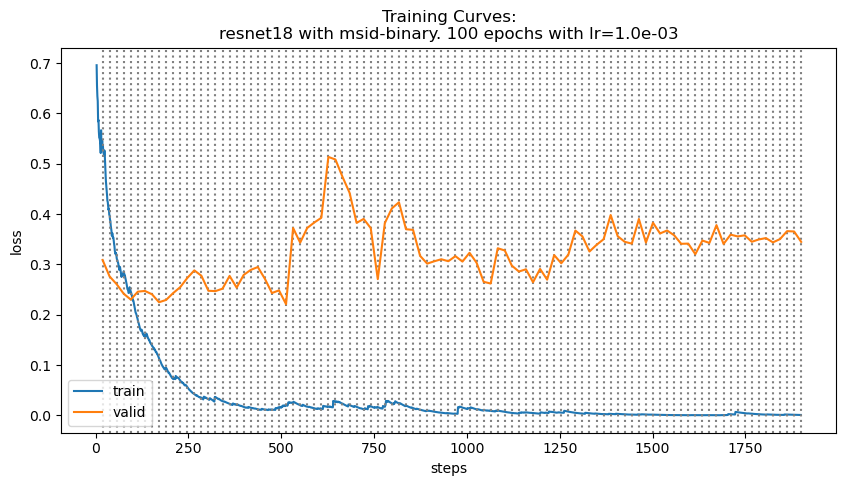

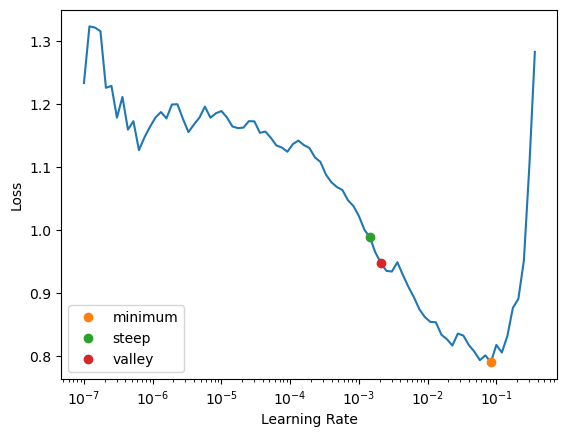

  Using valley learning rate: 2.09e-03

> Fine-tuning resnet18 on msid-binary for 100 epochs with batch size 16...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.832838,0.291441,0.912621,0.940000,0.902597,0.926108,00:01


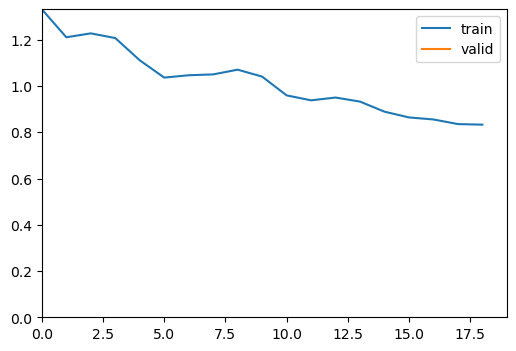

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.412366,0.223035,0.912621,0.949495,0.909091,0.930693,00:01
1,0.289421,0.194523,0.961165,0.951923,0.941558,0.956522,00:01
2,0.207497,0.191510,0.961165,0.951923,0.941558,0.956522,00:01
3,0.144060,0.180758,0.970874,0.952381,0.948052,0.961538,00:01
4,0.107948,0.171110,0.970874,0.961538,0.954545,0.966184,00:01
5,0.082256,0.164283,0.980583,0.952830,0.954545,0.966507,00:02
6,0.071094,0.153377,0.980583,0.952830,0.954545,0.966507,00:02
7,0.052467,0.157656,0.990291,0.962264,0.967532,0.976077,00:02
8,0.044934,0.183490,1.000000,0.944954,0.961039,0.971698,00:02
9,0.048796,0.212675,0.980583,0.943925,0.948052,0.961905,00:03


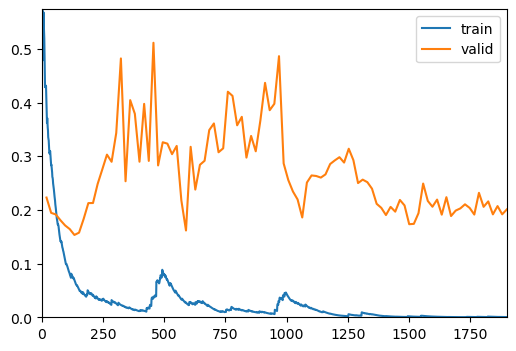

> Saving training records...
  Weights:  resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b.pth
  Metrics:  resnet18_100_16_2.1e-03_msid-binary_metrics_8c848f0d-1ca4-4503-9509-153c2308a88b.csv
  Losses:   resnet18_100_16_2.1e-03_msid-binary_losses_8c848f0d-1ca4-4503-9509-153c2308a88b.csv
  Metadata: resnet18_100_16_2.1e-03_msid-binary_metadata_8c848f0d-1ca4-4503-9509-153c2308a88b.txt
  Curves:   resnet18_100_16_2.1e-03_msid-binary_curves_8c848f0d-1ca4-4503-9509-153c2308a88b.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 100
Batch Size: 16
Learning Rate: 2.1e-03
Metrics:
	recall_score: 1.000000
	precision_score: 0.944954
	accuracy: 0.961039
	f1_score: 0.971698

UID: 8c848f0d-1ca4-4503-9509-153c2308a88b
----------------------------------------

Running experiment 3/4: bs=64
> Finding learning rate...


  lrs.minimum: 1.00e-02 
  lrs.steep  : 2.29e-06  
  lrs.valley : 2.09e-03


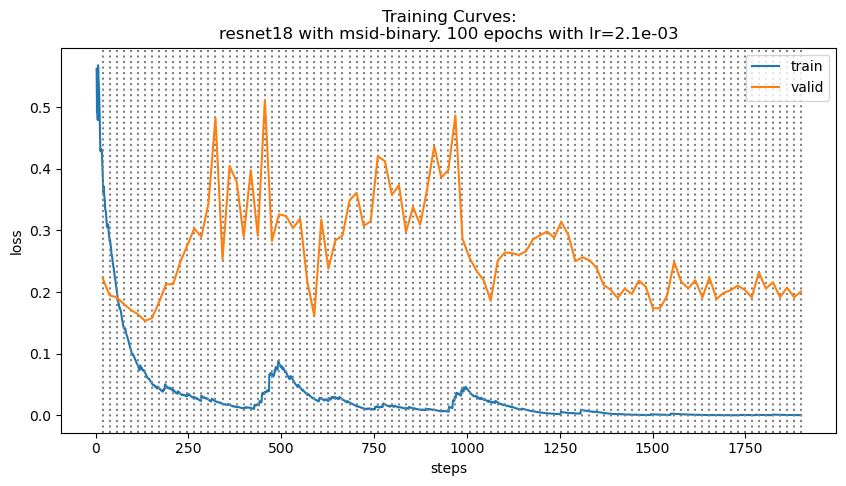

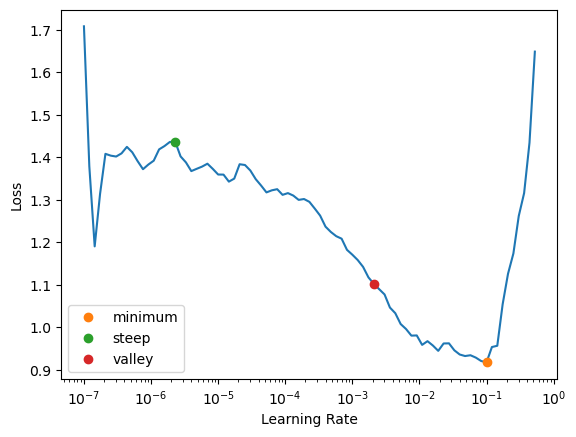

  Using valley learning rate: 2.09e-03

> Fine-tuning resnet18 on msid-binary for 100 epochs with batch size 64...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.857170,0.358693,0.951456,0.924528,0.915584,0.937799,00:01


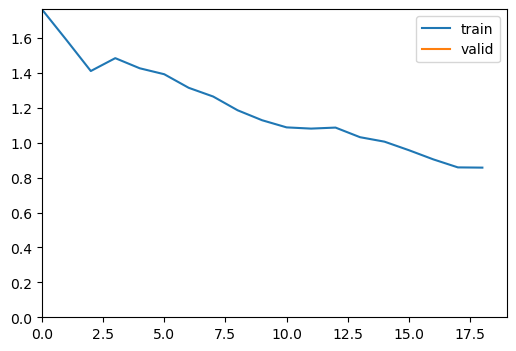

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.349695,0.351306,0.951456,0.933333,0.922078,0.942308,00:01
1,0.279364,0.326746,0.932039,0.950495,0.922078,0.941176,00:02
2,0.209956,0.263516,0.951456,0.951456,0.935065,0.951456,00:01
3,0.161833,0.256008,0.951456,0.960784,0.941558,0.956098,00:02
4,0.130259,0.251487,0.951456,0.942308,0.928571,0.946860,00:02
5,0.099306,0.253684,0.951456,0.951456,0.935065,0.951456,00:01
6,0.072697,0.289732,0.961165,0.951923,0.941558,0.956522,00:01
7,0.054927,0.288267,0.961165,0.951923,0.941558,0.956522,00:01
8,0.041703,0.263139,0.970874,0.943396,0.941558,0.956938,00:01
9,0.033716,0.282017,0.961165,0.951923,0.941558,0.956522,00:02


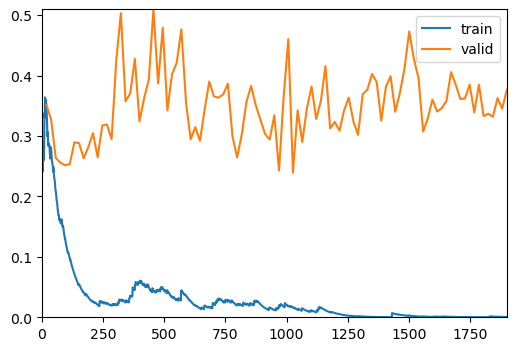

> Saving training records...
  Weights:  resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa.pth
  Metrics:  resnet18_100_64_2.1e-03_msid-binary_metrics_3f569899-955b-4e4a-81cc-da8970237baa.csv
  Losses:   resnet18_100_64_2.1e-03_msid-binary_losses_3f569899-955b-4e4a-81cc-da8970237baa.csv
  Metadata: resnet18_100_64_2.1e-03_msid-binary_metadata_3f569899-955b-4e4a-81cc-da8970237baa.txt
  Curves:   resnet18_100_64_2.1e-03_msid-binary_curves_3f569899-955b-4e4a-81cc-da8970237baa.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 100
Batch Size: 64
Learning Rate: 2.1e-03
Metrics:
	recall_score: 0.990291
	precision_score: 0.918919
	accuracy: 0.935065
	f1_score: 0.953271

UID: 3f569899-955b-4e4a-81cc-da8970237baa
----------------------------------------

Running experiment 4/4: bs=32
> Finding learning rate...


  lrs.minimum: 3.31e-03 
  lrs.steep  : 2.51e-03  
  lrs.valley : 1.45e-03


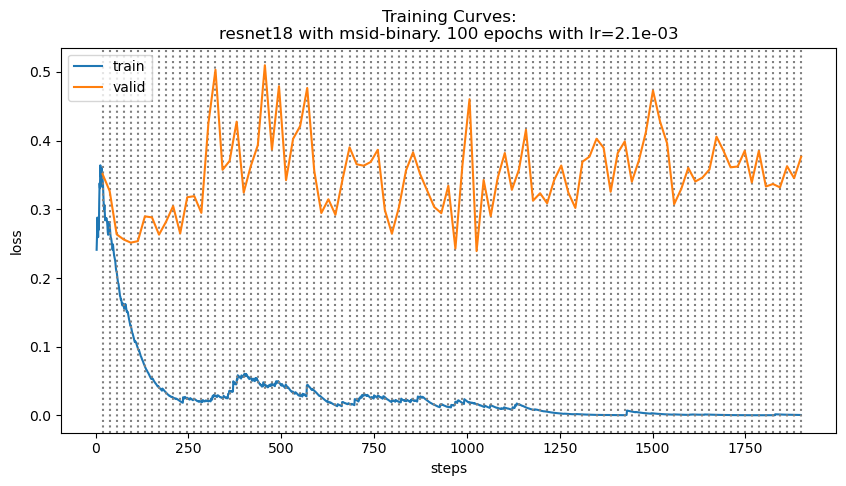

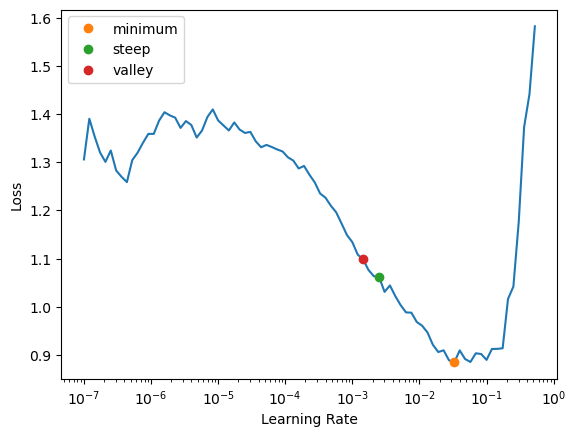

  Using valley learning rate: 1.45e-03

> Fine-tuning resnet18 on msid-binary for 100 epochs with batch size 32...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.868311,0.331818,0.941748,0.906542,0.896104,0.923810,00:02


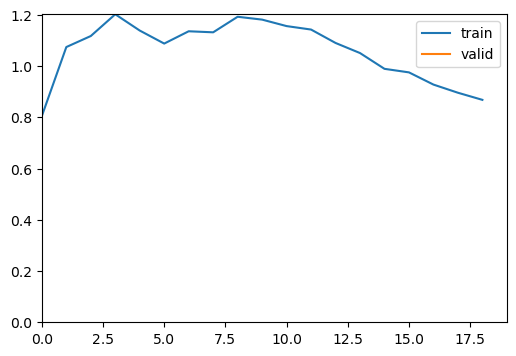

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.445052,0.341883,0.912621,0.949495,0.909091,0.930693,00:01
1,0.328471,0.271691,0.932039,0.932039,0.909091,0.932039,00:01
2,0.281055,0.250974,0.941748,0.941748,0.922078,0.941748,00:01
3,0.236933,0.263501,0.941748,0.941748,0.922078,0.941748,00:01
4,0.195293,0.251737,0.951456,0.942308,0.928571,0.946860,00:01
5,0.149543,0.245110,0.961165,0.942857,0.935065,0.951923,00:02
6,0.120803,0.251978,0.961165,0.942857,0.935065,0.951923,00:01
7,0.098746,0.244578,0.961165,0.942857,0.935065,0.951923,00:01
8,0.076306,0.228437,0.961165,0.951923,0.941558,0.956522,00:01
9,0.060283,0.252336,0.961165,0.942857,0.935065,0.951923,00:01


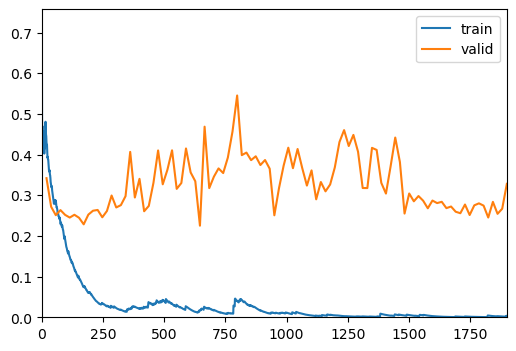

> Saving training records...
  Weights:  resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503.pth
  Metrics:  resnet18_100_32_1.4e-03_msid-binary_metrics_e8d9ede8-c3be-4d50-8d98-8967df07e503.csv
  Losses:   resnet18_100_32_1.4e-03_msid-binary_losses_e8d9ede8-c3be-4d50-8d98-8967df07e503.csv
  Metadata: resnet18_100_32_1.4e-03_msid-binary_metadata_e8d9ede8-c3be-4d50-8d98-8967df07e503.txt
  Curves:   resnet18_100_32_1.4e-03_msid-binary_curves_e8d9ede8-c3be-4d50-8d98-8967df07e503.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 100
Batch Size: 32
Learning Rate: 1.4e-03
Metrics:
	recall_score: 1.000000
	precision_score: 0.936364
	accuracy: 0.954545
	f1_score: 0.967136

UID: e8d9ede8-c3be-4d50-8d98-8967df07e503
----------------------------------------



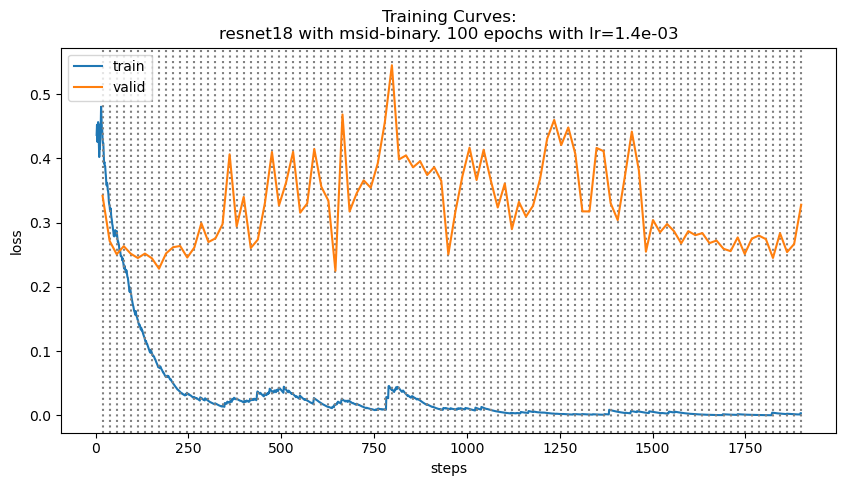

In [5]:
freeze_epochs = 1
n_epoch = 100
SAVE_RECORDS = True
# SAVE_RECORDS = False

hyperparams = (
    (None, 32),
    (None,16),
    (None,64),
    (None,32)
)
stats = []

for i, (lr, bs) in enumerate(hyperparams):
    print(f"Running experiment {i+1}/{len(hyperparams)}: bs={bs}")
    learn = run_experiment(
        resnet18,
        dls=dls,
        dataset='msid-binary',
        freeze_epochs=freeze_epochs, 
        n_epoch=n_epoch, 
        lr=lr, 
        bs=bs, 
        suggested_lr='valley',
        save_records=SAVE_RECORDS)
    print(f"{'-'*40}\n")

## Validation

In [5]:
dls_test = ImageDataLoaders.from_folder(data / 'MSLD-v1/Original', valid_pct=0.90, item_tfms=Resize(224))
print(f"Found {len(get_image_files(data / 'MSLD-v1/Original')):,} images in test set.")
dls_test.device

Found 228 images in test set.


device(type='cuda', index=0)

In [9]:
selected_arch = resnet18
dataset = 'msid-binary'

saved_model_files = model_weight_files(arch=selected_arch, dataset=dataset, dir_path=saved)
saved_model_files

[Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_32_1.0e-03_msid-binary_weights_1611e192-a43e-4540-9e4e-63de0cc809f2.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6.pth')]

In [ ]:
learn = vision_learner(
    dls_test,
    selected_arch,
    loss_func=CrossEntropyLossFlat(),
    metrics=[Recall(), Precision(), accuracy, F1Score()]
)

training_results = {}
validation_results = {}

for m in saved_model_files:
    print(f"Validating data from {dataset} with model {m.stem}")
    load_model(file=m, model=learn.model,opt=learn.opt, with_opt=False)
    res = learn.validate()
    validation_results[m.stem] = res

results_df = pd.DataFrame(validation_results, ).T
results_df.columns = ['val_loss']+[m.name for m in learn.recorder.metrics]
results_df.loc[:,['recall_score',	'precision_score',	'accuracy',	'f1_score']]

Validating data from msid-binary with model resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b


Validating data from msid-binary with model resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa


Validating data from msid-binary with model resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503


Validating data from msid-binary with model resnet18_100_32_1.0e-03_msid-binary_weights_1611e192-a43e-4540-9e4e-63de0cc809f2


Validating data from msid-binary with model resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6


,recall_score,precision_score,accuracy,f1_score
resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b,0.437500,1.000000,0.692683,0.608696
resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa,0.491071,0.982143,0.717073,0.654762
resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503,0.500000,0.965517,0.717073,0.658824
resnet18_100_32_1.0e-03_msid-binary_weights_1611e192-a43e-4540-9e4e-63de0cc809f2,0.517857,0.983051,0.731707,0.678363
resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6,0.437500,0.980000,0.687805,0.604938


## Review Model Features

In [8]:
selected_arch = resnet18
dataset = 'msid-binary'

pattern = re.compile(rf"{selected_arch.__name__}_.*{dataset}.*\.pth")
saved_model_files = [f for f in saved.iterdir() if pattern.match(f.name)]
saved_model_files

[Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_32_1.0e-03_msid-binary_weights_1611e192-a43e-4540-9e4e-63de0cc809f2.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6.pth')]

In [10]:
dataset_paths=['MSLD-v1/Original', 'MSID-binary', 'Monkeypox-dataset-2022/Monkeypox']
datasets = ['MSLD-v1', 'MSID-binary', 'Monkeypox-ds-2022-mpox']

features, labels = create_image_features(
    saved_model_file=saved_model_files[0],
    selected_arch=selected_arch,
    data_dir=data,
    dataset_paths=dataset_paths
)

features.shape, labels.shape, np.unique(labels)

((1041, 1024), (1041,), array([0, 1, 4, 5, 8]))

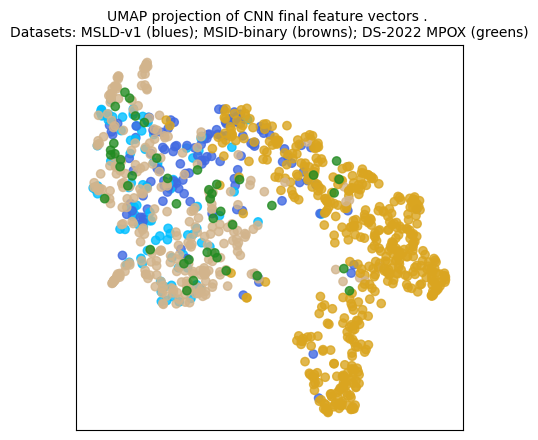

In [14]:
reducer = umap.UMAP()
reducer.fit(features)
embedding = reducer.transform(features)

fig, ax = plt.subplots(figsize=(5,5))
plot_features(embedding, labels, ax=ax)

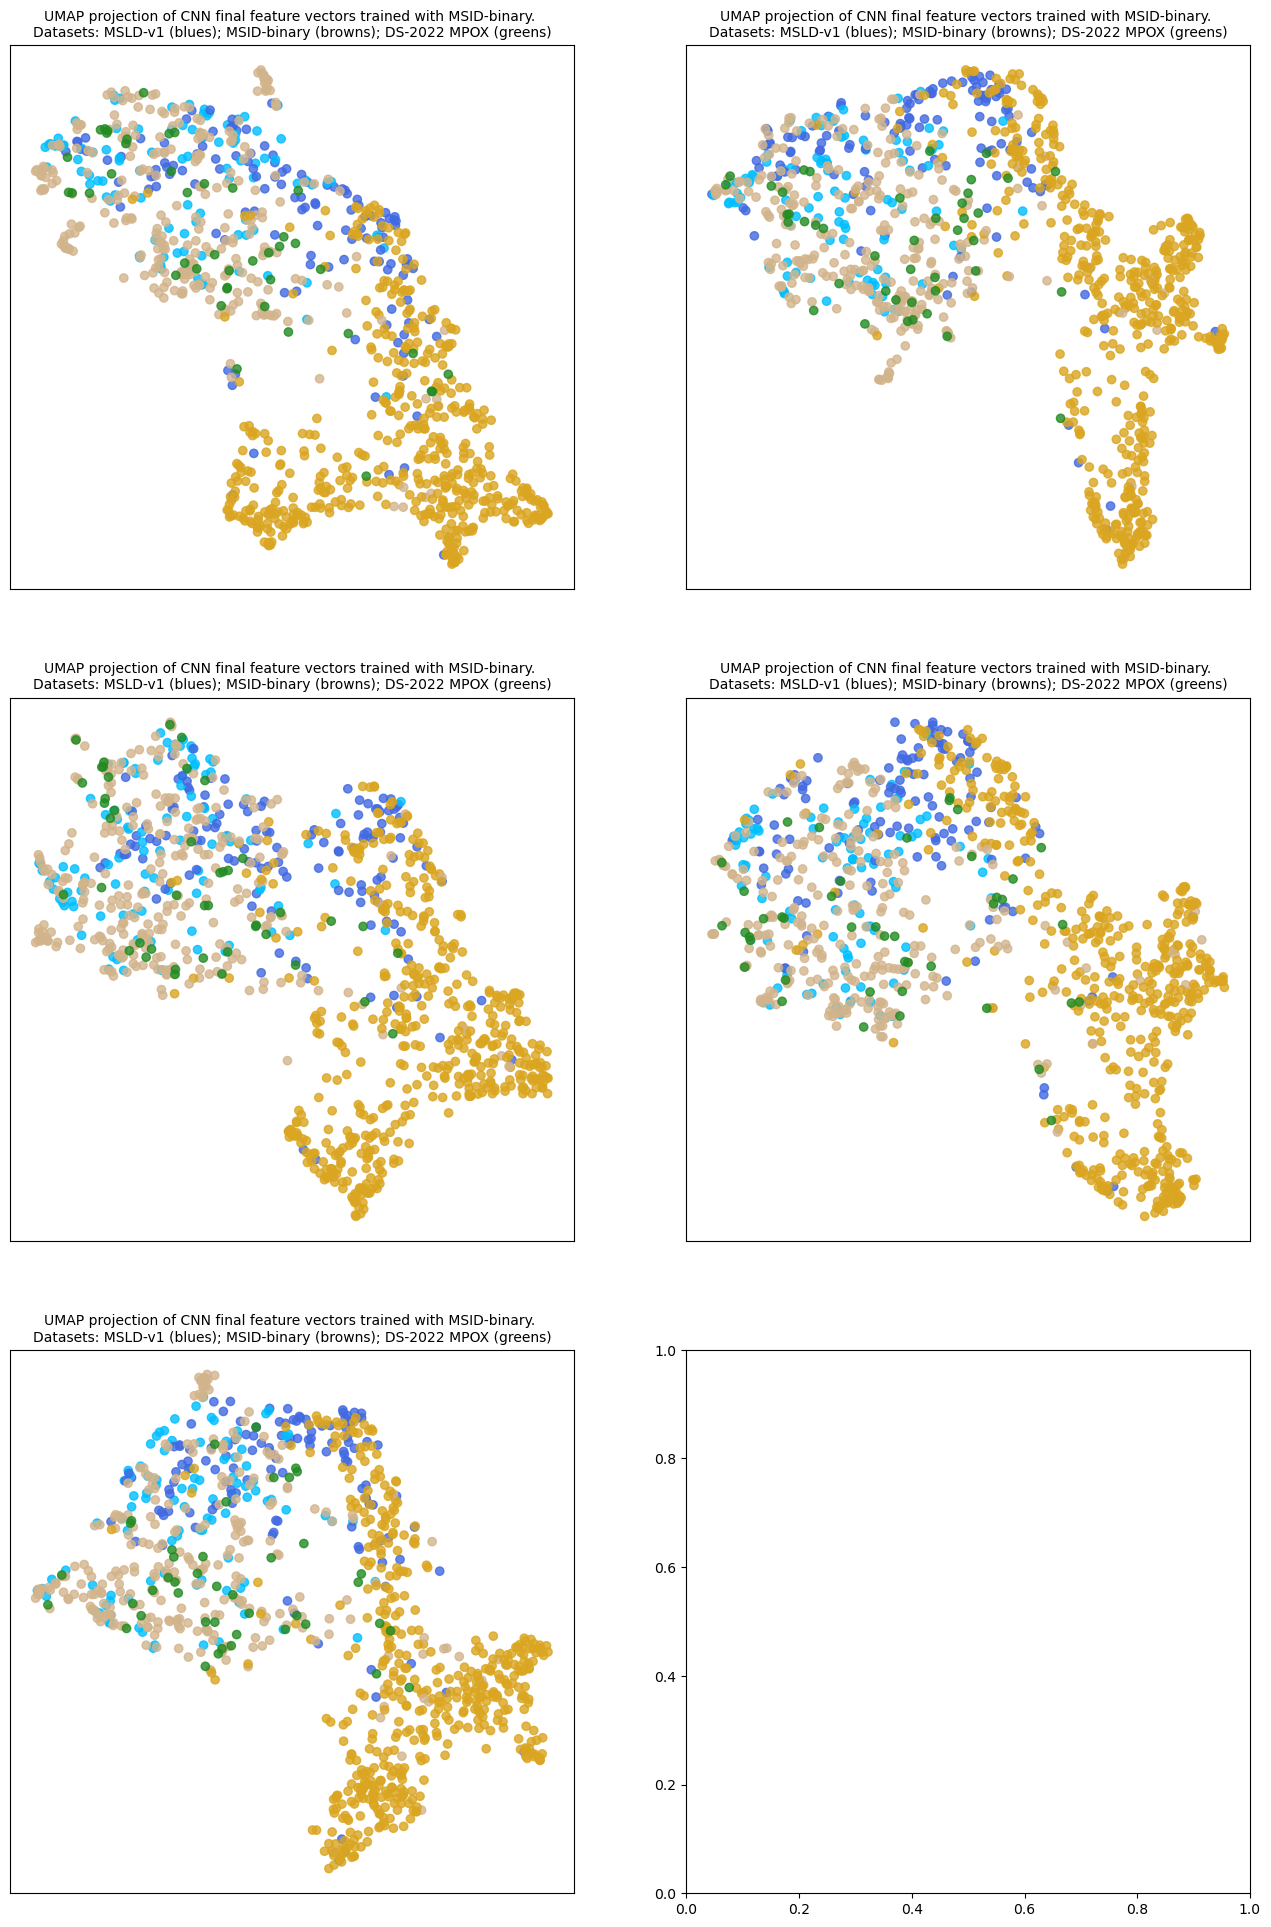

In [21]:
nb_models = len(saved_model_files)
dataset_paths=['MSLD-v1/Original', 'MSID-binary', 'Monkeypox-dataset-2022/Monkeypox']
datasets = ['MSLD-v1', 'MSID-binary', 'Monkeypox-ds-2022-mpox']


ncols = 2
nrows = (nb_models + ncols - 1) // ncols  # Calculate number of rows needed
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)
axs = axs.flatten() if nb_models > 1 else [axs]
for ax,model_file in zip(axs,saved_model_files):
    features, labels = create_image_features(
        saved_model_file=model_file,
        selected_arch=selected_arch,
        dataset_paths=dataset_paths,
        data_dir=data
    )
    reducer = umap.UMAP()
    reducer.fit(features)
    embedding = reducer.transform(features)
    plot_features(embedding, labels, ax=ax, training_ds=datasets[1])

In [ ]:
# import umap.plot
# umap.plot.points(reducer, labels=labels)

In [ ]:
# torch.cuda.is_available()
# torch.cuda.current_device()
# torch.cuda.get_device_name(torch.cuda.current_device())
# print(torch.device('cuda' if torch.cuda.is_available() else 'cpu')) 

In [ ]:
from PIL import Image

In [ ]:
p2img_dir = data / 'MSLD-v1/Original/Monkeypox'

# img = Image.open(p2img_dir / 'M01_01.jpg')
# img = Image.open(p2img_dir / 'M08_01.jpg')
img = Image.open(p2img_dir / 'M26_01.jpg')
# img = Image.open(p2img_dir / 'M49_02.jpg')
print(img.size)
img_384 = img.resize((384, 384), Image.LANCZOS)
img_384.save(data / f"{Path(img.filename).stem}_384.jpg")
img_1024 = img.resize((1024, 1024), Image.LANCZOS)
img_1024.save(data / f"{Path(img.filename).stem}_1024.jpg")